# Real Time Gait Asymmetry Detection  

In this notebook we are going to achieve the following:

1. **Create the Training Dataset**: We will preprocess and combine data from different sources to create a comprehensive training dataset for real time gait asymmetry detection.
2. **Feature Selection and Dimensionality Reduction**: We will identify the most relevant features for real time gait asymmetry detection using dimensionality reduction techniques.
3. **Model Evaluation**: We will test and compare the performance of multiple machine learning and deep learning algorithms for real time gait asymmetry detection.

In [ ]:
# Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from feature_extraction import generate_rolling_windows
from data_preprocessing import clean_extra_files, detection_merge_subject_features, detection_merge_raw_npz_files, detection_merge_csv_datasets, detection_merge_npz_datasets

# Constants
base_dir    = 'Data'
healthy_dir = 'Data/Healthy'
stroke_dir  = 'Data/Stroke'

detection_time_domain_name = 'detection_time_domain.csv'
detection_asymmetry_name   = 'detection_asymmetry.csv'

## Data Preprocessing, Feature Selection and Dimensionality Reduction

The first step is to create the dataset for the gait asymmetry and extract meaningful features from raw data. The goal is to create a set of different datasets that will provide a holistic view and different insights that we can use with the aim of creating a model that will provide a real time gait asymmetry detection. The process here includes the following steps:
1. Create a new base dataset that includes data in 2 second windows and a 1 second stride.
2. Extract simple statistic features from the 2 second signal like max, min and std. The simple statistics proved to be meaningful information for the classification task.
3. Extract a set of simple symmetry and asymmetry features from swing and stride times.

The data provided were designed for classification, since we have only a label for the whole signal as either 'Stroke Patient' or 'Healthy Subject'. In order to create the new real time asymmetry detection model we need to ensure that we have the correct labels. According to [Physio-pedia](https://www.physio-pedia.com/The_Gait_Cycle) the average gait cycle of a healthy adult is [1.2, 1.8] seconds. Taking into consideration the fact that impaired patients tend to have a longer stride we choose to use a 2 second window with a 1 second stride.

In [ ]:
# # Create the new datasets for the healthy subjects

# # 1. Create all the feature files for the statistical, asymmetry and raw data 
# for patient_id in os.listdir(healthy_dir):
#     patient_path = os.path.join(healthy_dir, patient_id)
    
#     if not os.path.isdir(patient_path) or patient_path.__contains__('.DS_Store'):
#         continue
    
#     try:
#         generate_rolling_windows(patient_path)
#     except Exception as e:
#         print(f'Error processing {patient_id}: {e}')
        
# # 2. Merge all type of datasets into a single file for better training
# detection_merge_subject_features(healthy_dir, detection_time_domain_name, detection_time_domain_name)
# detection_merge_subject_features(healthy_dir, detection_asymmetry_name, detection_asymmetry_name)
# detection_merge_raw_npz_files(healthy_dir)

In [ ]:
# # Create the new datasets for the stroke patients

# # 1. Create all the feature files for the statistical, asymmetry and raw data 
# for patient_id in os.listdir(stroke_dir):
#     patient_path = os.path.join(stroke_dir, patient_id)
    
#     if not os.path.isdir(patient_path) or patient_path.__contains__('.DS_Store'):
#         continue
    
#     try:
#         generate_rolling_windows(patient_path)
#     except Exception as e:
#         print(f'Error processing {patient_id}: {e}')
        
# # 2. Merge all type of datasets into a single file for better training
# detection_merge_subject_features(stroke_dir, detection_time_domain_name, detection_time_domain_name)
# detection_merge_subject_features(stroke_dir, detection_asymmetry_name, detection_asymmetry_name)
# detection_merge_raw_npz_files(stroke_dir)

In [ ]:
# # Merge the healthy subjects and stroke patients to a single file
# detection_merge_csv_datasets(healthy_dir, stroke_dir, detection_time_domain_name)
# detection_merge_csv_datasets(healthy_dir, stroke_dir, detection_asymmetry_name)
# detection_merge_npz_datasets(base_dir)

## Gait Asymmetry Detection — Time-Domain Feature Model

This part of the notebook trains a binary classifier to detect gait asymmetry using time-domain features extracted from rolling IMU windows.

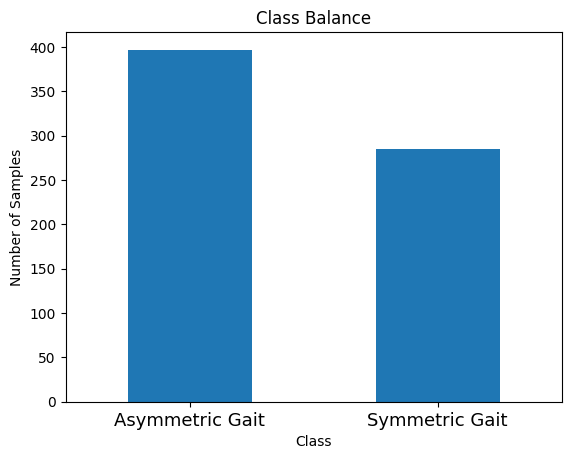

In [9]:
# Load Dataset
time_domain_data = pd.read_csv("detection_time_domain.csv")

# Filter for Gait Windows Only (label 0 or 1)
data_time_domain_gait = time_domain_data[time_domain_data['label_moderate'].isin([0, 1])].copy()
target_variable = 'label_moderate'

# Calculate class frequencies
class_counts = data_time_domain_gait[target_variable].value_counts()
bars = ['Asymmetric Gait', 'Symmetric Gait']
labels_position = np.arange(len(bars))


# Visualize class distribution
class_counts.plot(kind='bar')
plt.title('Class Balance')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(labels_position, bars, rotation=360, fontsize='13')
plt.show()


Training model: Random Forest
              precision    recall  f1-score   support

           0      0.522     0.537     0.529       361
           1      0.461     0.445     0.453       321

    accuracy                          0.494       682
   macro avg      0.491     0.491     0.491       682
weighted avg      0.493     0.494     0.494       682


Training model: Logistic Regression
              precision    recall  f1-score   support

           0      0.611     0.535     0.570       361
           1      0.541     0.617     0.576       321

    accuracy                          0.573       682
   macro avg      0.576     0.576     0.573       682
weighted avg      0.578     0.573     0.573       682


Training model: Gradient Boosting
              precision    recall  f1-score   support

           0      0.539     0.515     0.527       361
           1      0.481     0.505     0.492       321

    accuracy                          0.510       682
   macro avg      0.510  

,accuracy,f1_score_asymmetry,precision_asymmetry,recall_asymmetry
Logistic Regression,0.573314,0.576419,0.540984,0.616822
SVM (linear),0.535191,0.518968,0.505917,0.532710
Gradient Boosting,0.510264,0.492401,0.480712,0.504673
XGBoost,0.492669,0.462733,0.461300,0.464174
Random Forest,0.494135,0.453249,0.461290,0.445483
MLP,0.495601,0.452229,0.462541,0.442368


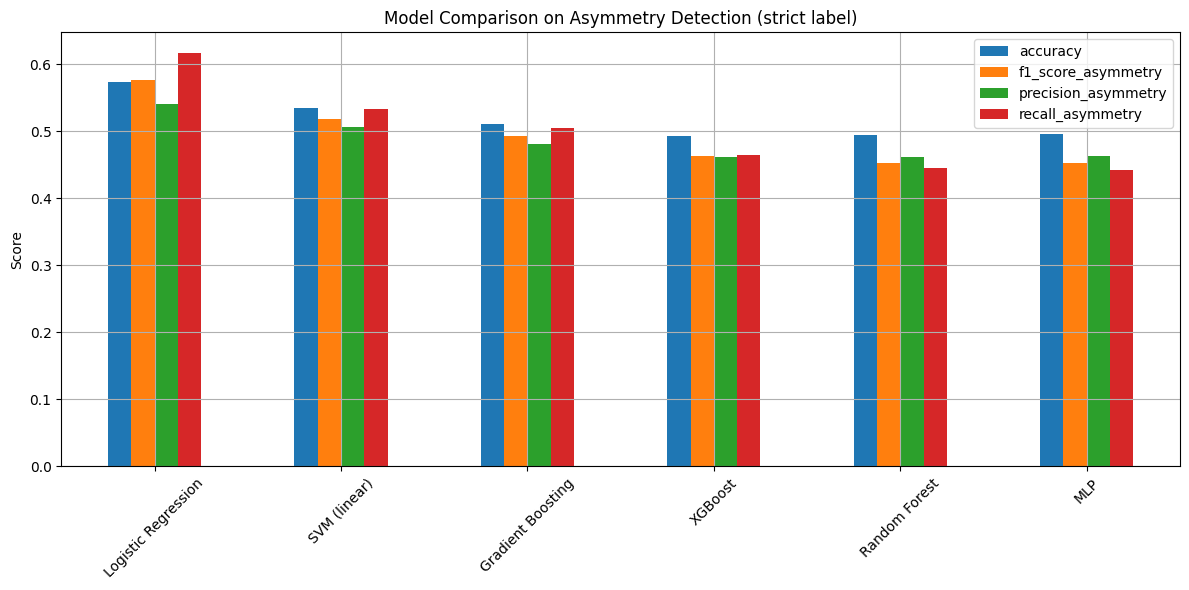


Training model: Random Forest
              precision    recall  f1-score   support

           0      0.385     0.340     0.361       285
           1      0.563     0.610     0.585       397

    accuracy                          0.497       682
   macro avg      0.474     0.475     0.473       682
weighted avg      0.488     0.497     0.492       682


Training model: Logistic Regression
              precision    recall  f1-score   support

           0      0.351     0.119     0.178       285
           1      0.571     0.841     0.680       397

    accuracy                          0.540       682
   macro avg      0.461     0.480     0.429       682
weighted avg      0.479     0.540     0.470       682


Training model: Gradient Boosting
              precision    recall  f1-score   support

           0      0.373     0.319     0.344       285
           1      0.557     0.615     0.584       397

    accuracy                          0.491       682
   macro avg      0.465  

,accuracy,f1_score_asymmetry,precision_asymmetry,recall_asymmetry
SVM (linear),0.570381,0.716908,0.581505,0.934509
Logistic Regression,0.539589,0.680244,0.570940,0.841310
MLP,0.536657,0.663830,0.574586,0.785894
XGBoost,0.535191,0.614824,0.593897,0.637280
Random Forest,0.497067,0.585248,0.562791,0.609572
Gradient Boosting,0.491202,0.584431,0.557078,0.614610


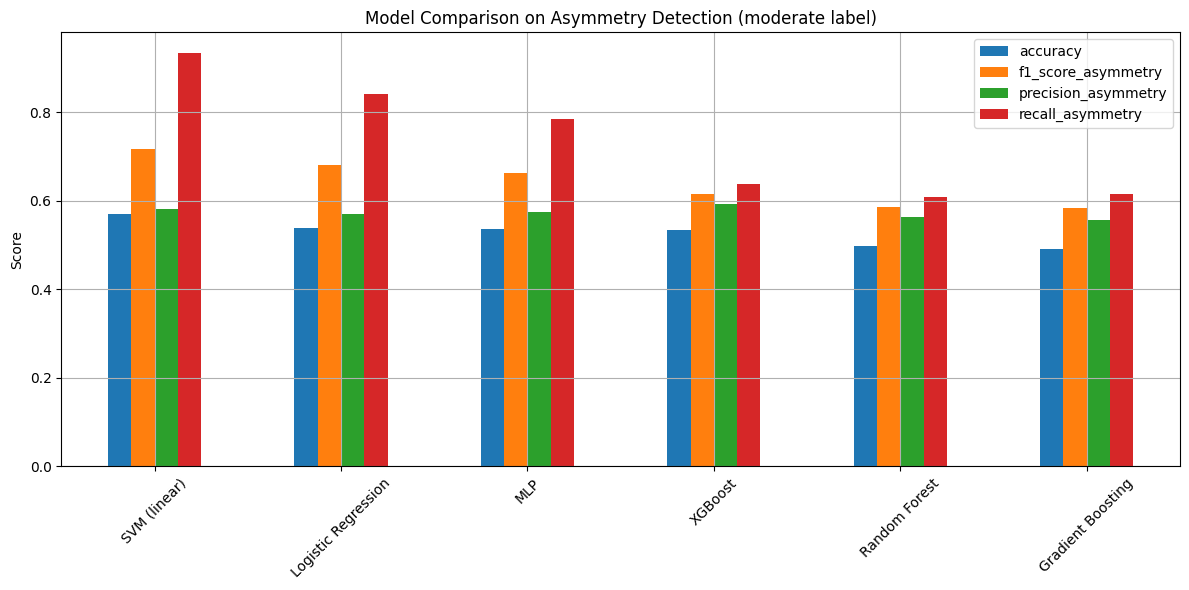


Training model: Random Forest
              precision    recall  f1-score   support

           0      0.186     0.056     0.086       197
           1      0.701     0.901     0.789       485

    accuracy                          0.657       682
   macro avg      0.444     0.478     0.437       682
weighted avg      0.553     0.657     0.586       682


Training model: Logistic Regression
              precision    recall  f1-score   support

           0      0.152     0.036     0.058       197
           1      0.701     0.920     0.796       485

    accuracy                          0.664       682
   macro avg      0.427     0.478     0.427       682
weighted avg      0.543     0.664     0.583       682


Training model: Gradient Boosting
              precision    recall  f1-score   support

           0      0.250     0.086     0.128       197
           1      0.707     0.895     0.790       485

    accuracy                          0.661       682
   macro avg      0.478  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

           0      0.213     0.132     0.163       197
           1      0.695     0.802     0.744       485

    accuracy                          0.609       682
   macro avg      0.454     0.467     0.454       682
weighted avg      0.556     0.609     0.577       682


 Model Comparison Summary:


,accuracy,f1_score_asymmetry,precision_asymmetry,recall_asymmetry
SVM (linear),0.711144,0.831191,0.711144,1.000000
MLP,0.671554,0.800357,0.704867,0.925773
Logistic Regression,0.664223,0.795718,0.701258,0.919588
Gradient Boosting,0.661290,0.789809,0.706840,0.894845
Random Forest,0.656891,0.788809,0.701445,0.901031
XGBoost,0.608504,0.744498,0.694643,0.802062


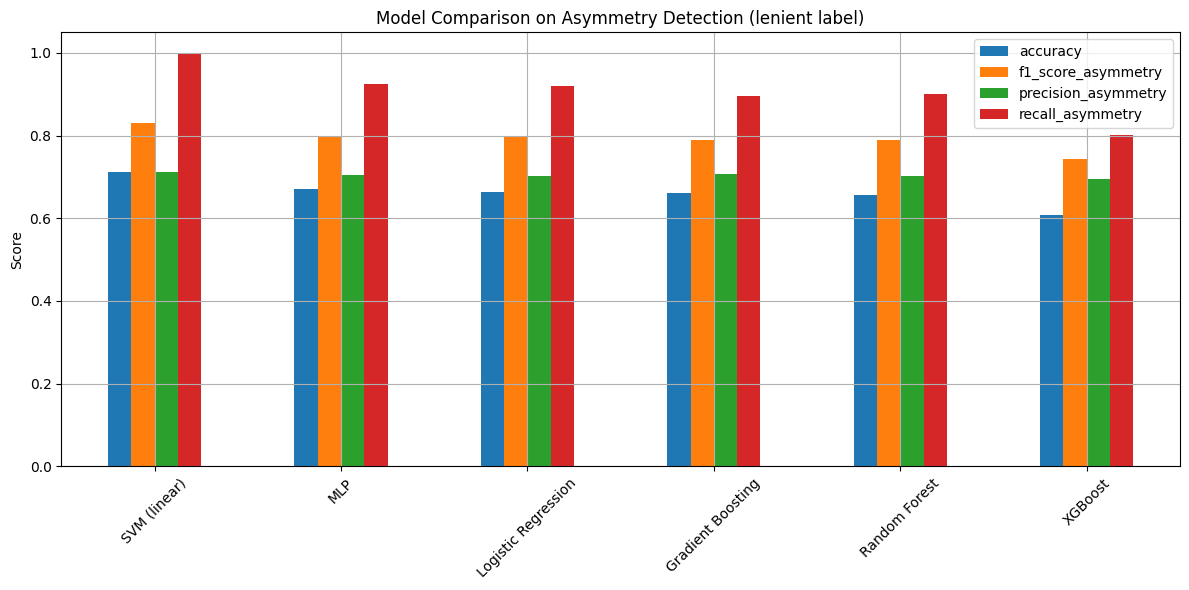

In [10]:
# Define Features and Labels
feature_cols = [
    'gyro-right-z-axis-max', 'gyro-left-z-axis-max',
    'gyro-right-z-axis-min', 'gyro-left-z-axis-min',
    'accel-right-z-axis-max', 'accel-left-z-axis-max',
    'accel-right-z-axis-min', 'accel-left-z-axis-min'
]

labels = ['label_strict', 'label_moderate', 'label_lenient']


for label in labels:
    label_type = label.split('_')[1]
    X = data_time_domain_gait[feature_cols].values
    y = data_time_domain_gait[label].values
    groups = data_time_domain_gait['patient_id'].values

    # Normalize Features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Cross-Validation Setup
    gkf = GroupKFold(n_splits=5)

    # Define All Models to Compare
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Gradient Boosting": GradientBoostingClassifier(),
        "MLP": MLPClassifier(hidden_layer_sizes=(50,), max_iter=3000, alpha=1e-4),
        "SVM (linear)": SVC(kernel='linear', probability=True),
        "XGBoost": xgb.XGBClassifier(eval_metric='logloss')
    }


    # Train and Evaluate All Models
    results = {}

    for name, model in models.items():
        print(f"\nTraining model: {name}")
        y_true_all, y_pred_all = [], []

        # Training and Evaluation
        for fold, (train_idx, test_idx) in enumerate(gkf.split(X_scaled, y, groups)):
                model.fit(X_scaled[train_idx], y[train_idx])
                y_pred = model.predict(X_scaled[test_idx])
                y_true_all.extend(y[test_idx])
                y_pred_all.extend(y_pred)
                
        report = classification_report(y_true_all, y_pred_all, output_dict=True)
        results[name] = report
        print(classification_report(y_true_all, y_pred_all, digits=3))



    # Compare Models (Accuracy and F1)
    summary = pd.DataFrame({
        model: {
            "accuracy": results[model]["accuracy"],
            "f1_score_asymmetry": results[model]["1"]["f1-score"],
            "precision_asymmetry": results[model]["1"]["precision"],
            "recall_asymmetry": results[model]["1"]["recall"]
        }
        for model in results
    }).T


    summary = summary.sort_values(by="f1_score_asymmetry", ascending=False)
    print("\n Model Comparison Summary:")
    display(summary)

    # ## Plot Summary
    summary.plot(kind="bar", figsize=(12,6))
    plt.title(f"Model Comparison on Asymmetry Detection ({label_type} label)")
    plt.ylabel("Score")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Results 

| Label Type       | Behavior                                                 |
| ---------------- | -------------------------------------------------------- |
| `label_strict`   | Low recall, very few positive samples, ~60% performance  |
| `label_moderate` | Balanced but noisy performance                           |
| `label_lenient`  | Higher F1 and accuracy (~80%)                           |



### Why label_lenient Performs Better?

1. More positive-asymmetry samples:
    - The model has more training signal instances
    - Reduces the label sparsity between the two classes

2. Less ambiguous class boundaries:
    - Even mild asymmetry windows become "positives"

3. Possibly better idea in practice since:
    - Mild asymmetries do matter in stroke rehab
    - Detecting early signs may be more useful than catching only extreme events

<br><br/>
With the current solution we likely get:

- **More false positives**
- But also more opportunities for timely correction

A tradeoff we are willing to make in stroke patients rehab to ensure that even in smaller cases of asymmetry we provide opportunities for the user to correct the gait cycle.

## 2. Stride times Asymmetry values

In [4]:
import numpy as np

# Load the uploaded .npz file
raw_data = np.load("all_subject_raw_windows.npz")
X_raw = raw_data["X"]
print(X_raw)

[[[-3.41500e+00  0.00000e+00  1.95100e+00 ...  8.03900e+00 -4.41700e+00
   -9.19000e-01]
  [-3.41500e+00  0.00000e+00  1.95100e+00 ...  8.03900e+00 -4.41700e+00
   -9.19000e-01]
  [-3.35400e+00 -6.10000e-02  2.19500e+00 ...  8.03900e+00 -4.41700e+00
   -9.19000e-01]
  ...
  [-6.31100e+01 -4.62200e+01  1.75000e+01 ...  1.17190e+01  1.67500e+00
    2.12900e+00]
  [-6.31100e+01 -4.62200e+01  1.75000e+01 ...  1.17190e+01  1.67500e+00
    2.12900e+00]
  [-8.14630e+01 -5.26830e+01  4.70730e+01 ...  1.28430e+01  3.94300e+00
   -1.44000e+00]]

 [[-7.61590e+01 -3.87200e+01  1.06220e+02 ...  8.12000e+00  1.70400e+00
    1.48300e+00]
  [-7.61590e+01 -3.87200e+01  1.06220e+02 ...  1.05180e+01  5.89100e+00
    9.04000e-01]
  [-7.61590e+01 -3.87200e+01  1.06220e+02 ...  1.14700e+01  5.07200e+00
   -1.51700e+00]
  ...
  [ 2.82320e+01  1.22000e-01  7.93000e-01 ...  8.00600e+00 -3.20100e+00
   -8.90000e-01]
  [ 2.82320e+01  1.22000e-01  7.93000e-01 ...  8.00600e+00 -3.20100e+00
   -8.90000e-01]
  [ 2.8

## 3. Raw data values

In [ ]:
clean_extra_files(healthy_dir)
clean_extra_files(stroke_dir)